# Rectified Diffusion

Rectified Diffusion: Straightness Is Not Your Need in Rectified Flow, Wang et al., 2024. [[arXiv:2410.07303](https://arxiv.org/abs/2410.07303)]

## 1. Prepare Dataset

Define the gaussian mixture distribution as the target distribution.

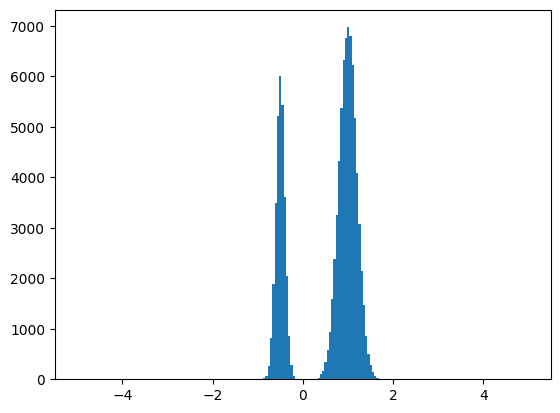

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import gmm

X, Y = gmm(100000, weights=[0.3, 0.7], mean=[-0.5, 1.0], std=[0.1, 0.2])

_ = plt.hist(X, bins=np.linspace(-5, 5, 200), label="data")

## 2. Define Score Model

Define MLP backbone and score model first.

In [2]:
from flowmodels import DDPM, DDIMScheduler
from utils import Backbone

COND = True
aux = 1 if not COND else 2
model = DDPM(Backbone(aux=aux), DDIMScheduler())
model

DDPM(
  (noise_estim): Backbone(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

## 3. Train Score Model

Train the score model with the prepared dataset.

  0%|          | 0/1000 [00:00<?, ?it/s]

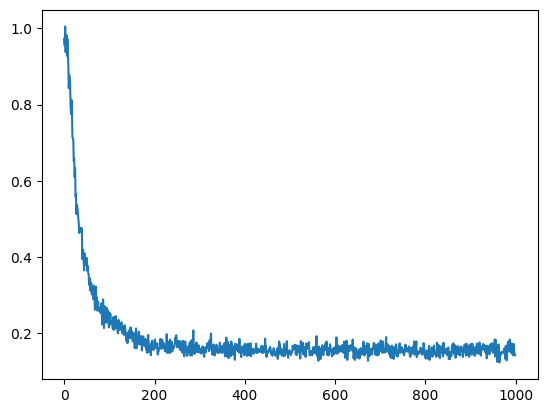

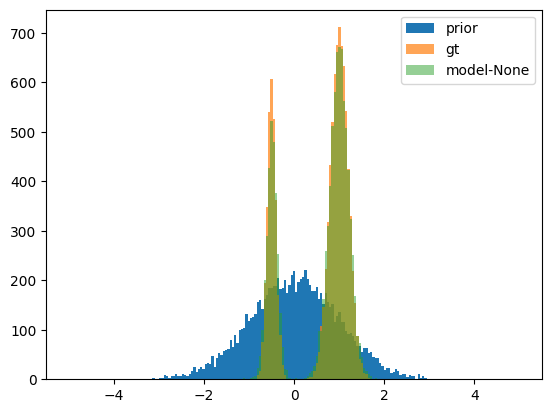

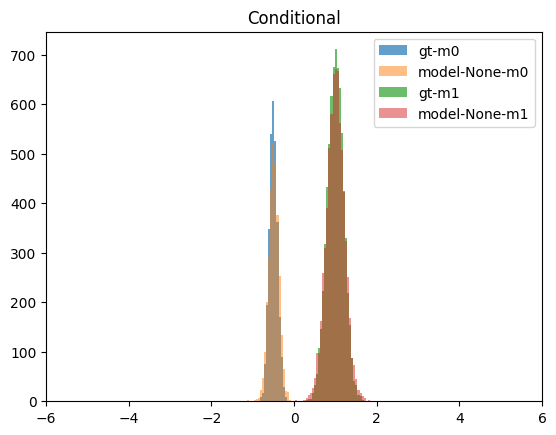

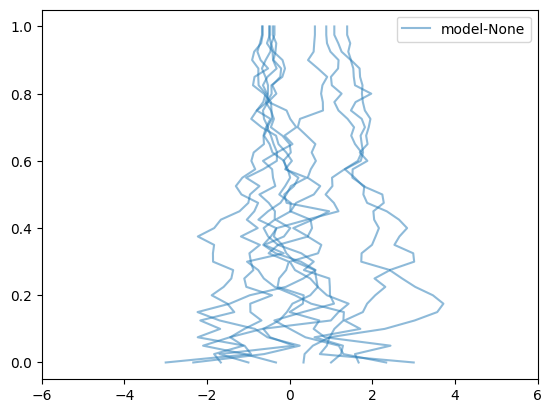

In [3]:
import torch
from tqdm.auto import tqdm

from utils import vis

# training configurations
LR = 0.001
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

# train
model.train()
optim = torch.optim.Adam(model.parameters(), LR)

losses = []
with tqdm(range(TRAIN_STEPS)) as pbar:
    for i in pbar:
        indices = torch.randint(0, len(X), (BATCH_SIZE,))
        loss = model.loss(
            sample=X[indices],
            label=Y[indices] if COND else None,
        )
        # update
        optim.zero_grad()
        loss.backward()
        optim.step()

        # log
        loss = loss.detach().item()
        losses.append(loss)
        pbar.set_postfix_str(f"loss: {loss:.2f}")

plt.plot(losses)
vis(model, conditional=COND, steps=[None])

## 4. Distill to Rectified Diffusion

Distill the knowledge of the pretrained score model to Rectified Diffusion

In [4]:
import copy

import torch.nn as nn

from flowmodels.rd import RectificationSupports


class _Wrapper(nn.Module, RectificationSupports):
    def __init__(self, ddpm: DDPM):
        super().__init__()
        self.ddpm = copy.deepcopy(ddpm)
        # overwriting
        self.scheduler = self.ddpm.scheduler
        self.score = self.ddpm.score
        self.loss = self.ddpm.loss

    def forward(
        self, x_t: torch.Tensor, t: torch.Tensor, label: torch.Tensor | None = None
    ):
        # convert t in range[0, 1] to range[0, T]
        return self.ddpm.forward(x_t, (t * self.scheduler.T).long(), label=label)

    def noise(
        self, x_0: torch.Tensor, t: torch.Tensor, eps: torch.Tensor | None = None
    ):
        # convert t in range[1/T, 1] to range[1, T]
        return self.ddpm.noise(x_0, (t * self.scheduler.T).long(), eps)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

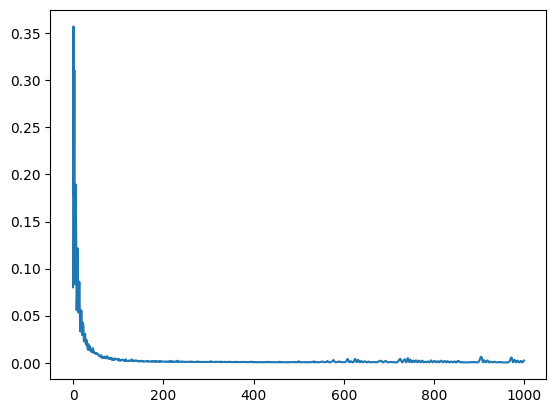

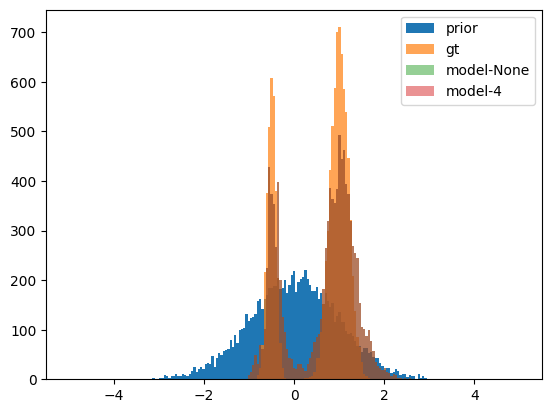

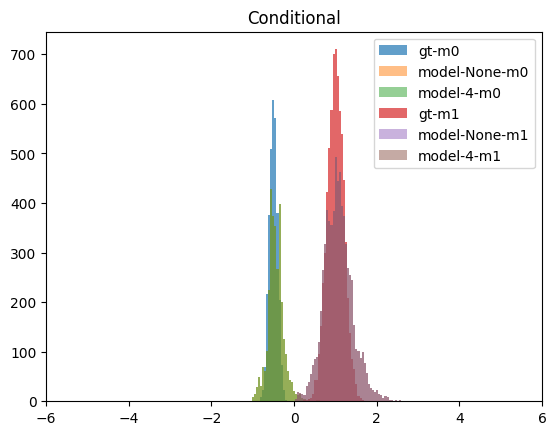

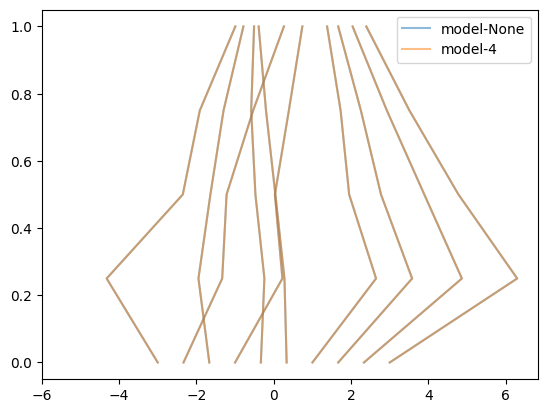

In [5]:
from flowmodels import RecitifedDiffusion

# define rectified diffusion
rd = RecitifedDiffusion(_Wrapper(model))

# distillation
LR = 0.001
SAMPLE_STEPS = 100
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

n = 10000
prior = torch.randn(n, X.shape[-1])
optim = torch.optim.Adam(rd.parameters(), LR)
losses, rctor = rd.rectify(
    optim,
    prior,
    TRAIN_STEPS,
    BATCH_SIZE,
    label=Y[torch.randperm(len(Y))[:n]] if COND else None,
    verbose=lambda r: tqdm(r, leave=False),
)
plt.plot(losses)
vis(rd, conditional=COND, steps=[None, 4])

### Distillation

Distill the model for single-step generation

  0%|          | 0/1000 [00:00<?, ?it/s]

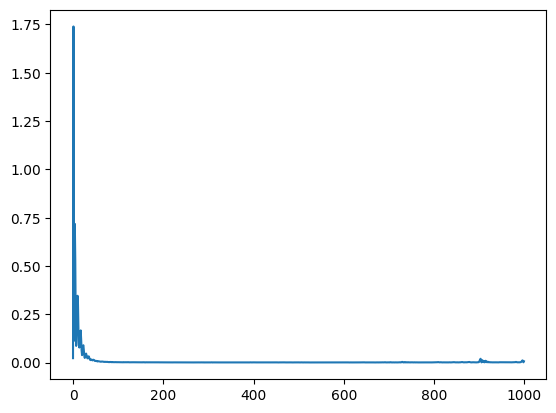

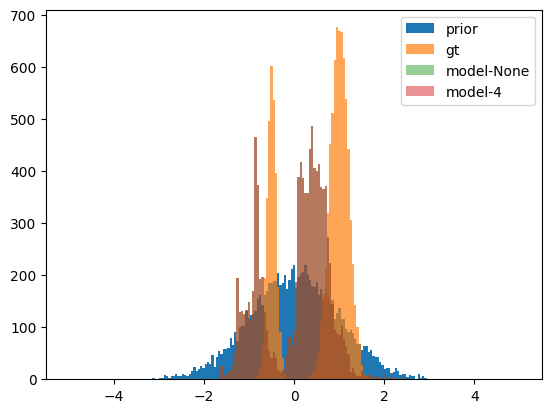

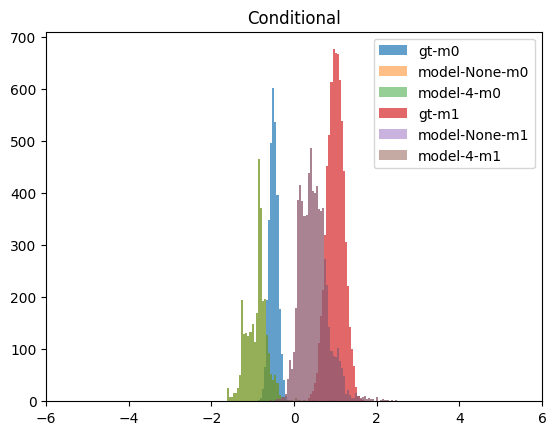

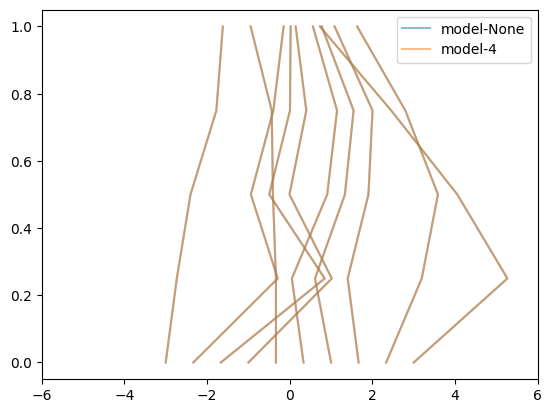

In [6]:
# REFLOW
LR = 0.001
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

n = 10000
prior = torch.randn(n, X.shape[-1])

distill = copy.deepcopy(rd)
optim = torch.optim.Adam(distill.parameters(), LR)
losses = distill.consistency_distillation(
    optim,
    prior,
    training_steps=TRAIN_STEPS,
    batch_size=BATCH_SIZE,
    label=Y[torch.randperm(len(Y))[:n]] if COND else None,
    verbose=lambda x: tqdm(x, leave=False),
)

plt.plot(losses)
vis(distill, conditional=COND, steps=[None, 4])